##  Classification and Visualization


https://en.wikipedia.org/wiki/Multi-label_classification

In [25]:
from __future__ import print_function
import torch
import torch.nn as nn

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys

import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

from textwrap import wrap
from itertools import compress


In [26]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
import MonaLIA.util.visualization_helpers as vis
import MonaLIA.model.train as model
import MonaLIA.data.image_transforms
import MonaLIA.data.image_dataset

importlib.reload(MonaLIA.util.visualization_helpers)
importlib.reload(MonaLIA.model.train)
importlib.reload(MonaLIA.data.image_transforms)
importlib.reload( MonaLIA.data.image_dataset)
    
from MonaLIA.data import image_transforms
from MonaLIA.data import image_dataset

from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.binary_subset import BinarySubset
from MonaLIA.data.image_transforms import NormalizeMultiCrop, PadToSquare

from MonaLIA.util.visualization_helpers import target_to_text, prediction_to_text
from MonaLIA.util.visualization_helpers import show_confusion_matrix, show_random_images, image_tensor_to_np
from MonaLIA.util.visualization_helpers import visualize_classification_HTML as display_HTML
from MonaLIA.util.visualization_helpers import compare_classification_HTML as display_compare_HTML

In [27]:
print('PyTorch ver.' ,  torch.__version__ )
print('torchvision ver.' ,  torchvision.__version__ )
print('cuda ver.', torch.version.cuda)
print('sckit-learn ver.', sklearn.__version__)
print('matplotlib ver.', matplotlib.__version__)
print('pandas ver.', pd.__version__)

PyTorch ver. 1.5.0
torchvision ver. 0.6.0
cuda ver. 10.2
sckit-learn ver. 0.22.1
matplotlib ver. 3.1.3
pandas ver. 1.0.1


### Load Data

In [245]:
dataset = 'Joconde'

if dataset == 'Joconde':
    images_root = 'C:/Joconde/joconde'
    descr_path = 'C:/Datasets/Joconde/Themes'
    image_description_file = os.path.join(descr_path, 'dataset4.csv')
    exclude_labels = []# ['espèce animale+être humain' , 'none+none'] 

elif dataset == 'ImageNet': # refactor
    images_root = 'Z:\Documents\Python Scripts\data\ImageNet'

else:
    raise ValueError('unknown dataset')


multi_label = False
multi_crop = False
batch_size = 4

model_name = 'inception_v3'
#model_param_file = '../output/Inception_v3_Joconde_40_classes.1000.1.pth'
model_checkpoint_file = '../../output/Inception_v3_Joconde_themes.1000.4.checkpoint.pth.tar'

model_image_size = 299

In [246]:
if model_name == 'inception_v3':
    dataset_mean =  [0.5, 0.5, 0.5]
    dataset_std  =  [0.5, 0.5, 0.5]

elif model_name == 'vgg16_bn':
    if dataset == 'Joconde':
        dataset_mean =  image_transforms.joconde_mean_animals 
        dataset_std  =  image_transforms.joconde_std_animals 
    else:
        dataset_mean =  image_transforms.imagenet_mean 
        dataset_std  =  image_transforms.imagenet_std
        
else:
    raise ValueError('unexplored model')
    
if (multi_crop):
    test_trans = transforms.Compose([
                    transforms.Resize(max(256, model_image_size)),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean,
                                         std = dataset_std)
                    ])
else:

    test_trans = transforms.Compose([
        #PadToSquare(padding_mode='wrap'),
        #transforms.Resize((model_image_size, model_image_size)), 
        transforms.Resize(model_image_size),
        transforms.CenterCrop(model_image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = dataset_mean,
                             std = dataset_std),
    ])
    

if dataset == 'Joconde':
    test_set = JocondeDataset(image_description_file, 
                            images_root,
                            dataset_name = 'themes',
                            exclude_labels=exclude_labels  ,
                            label_column='theme_label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=test_trans)

elif dataset == 'ImageNet':
    test_set = dset.ImageFolder(root=os.path.join(images_root, 'test'),  transform=test_trans)


test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

class_count = len(test_set.classes)
class_names = test_set.classes

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()

Test Dataset JocondeDataset
    Number of datapoints: 1199
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Themes\dataset4.csv
    Number of classes: 12
    Number of uniqie labels: 12
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'figure': 100, 'nature morte': 99, 'ornementation': 100, 'paysage': 100, 'portrait': 100, 'représentation animalière': 100, "représentation d'objet": 100, 'représentation non figurative': 100, 'représentation scientifique': 100, 'représentation végétale': 100, 'scène': 100, "vue d'architecture": 100}



### Read metrics from the cluster run

In [248]:
print(model_checkpoint_file)
checkpoint = torch.load(model_checkpoint_file)
print(checkpoint.keys())

../output/Inception_v3_Joconde_themes.1000.4.checkpoint.pth.tar
dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time', 'metrics_history'])


In [252]:
checkpoint['classes']

['figure',
 'nature morte',
 'ornementation',
 'paysage',
 'portrait',
 'représentation animalière',
 "représentation d'objet",
 'représentation non figurative',
 'représentation scientifique',
 'représentation végétale',
 'scène',
 "vue d'architecture"]

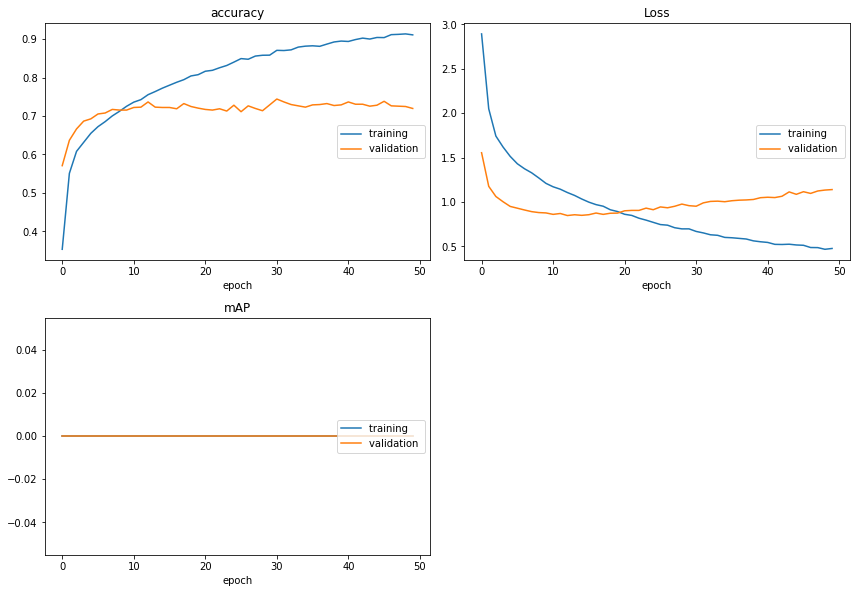

accuracy
	training         	 (min:    0.225, max:    1.000, cur:    0.911)
	validation       	 (min:    0.417, max:    0.999, cur:    0.720)
Loss
	training         	 (min:    0.000, max:    3.630, cur:    0.478)
	validation       	 (min:    0.006, max:    2.295, cur:    1.141)
mAP
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Best model training accuracy: 0.9133
Best model validation accuracy: 0.7441
Best model epoch: 31
Training time: 2:29:17.578149


In [254]:
from livelossplot import PlotLosses

#model_metrics_file = '../output/loss study/inception_v3_Joconde_themes.1000.val_trans_no_aux_loss.csv'
#metrics_df = pd.read_csv(model_metrics_file)
#metrics_df.loss = metrics_df.loss.str[7:13].astype(float, 4)
metrics_df = pd.DataFrame(checkpoint['metrics_history'])
liveloss_cluster = PlotLosses()#(max_epoch=metrics_df.shape[0], max_cols=2)

for i, row in metrics_df.iterrows():
    epoch_stats ={}
    for col in metrics_df.columns[0:]:#.sort_values(ascending=False):
        epoch_stats[col] = row[col]
    #print(epoch_stats)
    
    liveloss_cluster.update(epoch_stats)
    
liveloss_cluster.draw()

print('Best model training accuracy: %.4f' % metrics_df.accuracy.max())
print('Best model validation accuracy: %.4f' % metrics_df.val_accuracy.max())
print('Best model epoch: %d' %  (metrics_df.val_accuracy.idxmax() + 1))
print('Training time: %s' % checkpoint['elapsed_time'])


## Adjust if Binary

In [16]:
class_count = len(checkpoint['classes'])

if(class_count == 2):

    test_set = BinarySubset(test_set, 'lion')
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

    class_count = len(test_set.classes)
    class_names = test_set.classes

    print('Test', test_set)
    print('    Labels:', test_set.labels_count)
    print()


Test Dataset BinarySubset
    Number of datapoints: 126
    Root location: C:/Joconde/joconde
    Number of classes: 2
    Number of positive labels: 63
    Number of negative labels: 63
    Labels: {'~lion': 63, 'lion': 63}



### Load Model

In [255]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print('Using cuda? ', use_cuda)

net = model.load_net(model_name = model_name, class_count=class_count)
#net = torchvision.models.Inception3(num_classes=18, aux_logits=False, transform_input=False, init_weights=False)
#net.load_state_dict(torch.load(model_param_file))
net.load_state_dict(checkpoint['state_dict'])
net = net.to(device)
print(net.transform_input)

Using cuda?  True
False


### Run Model

In [259]:
model_checkpoint_file = '../output/Inception_v3_Joconde_themes.1000.4.best.pth.tar'
checkpoint = torch.load(model_checkpoint_file)
print(checkpoint.keys())

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time', 'metrics_history'])


In [261]:
th = checkpoint['threshold']#.round(2)
print(th)

0.5


In [262]:
activation = torch.softmax
decision = model.decision_by_max
decision_param = th

In [263]:
scores = model.predict(net, test_loader, activation, decision, decision_param)

images total: 1000, correct: 749, acc: 74.9% , mAP: 0.000
images total: 1199, correct: 881, acc: 73.5% , mAP: 0.000
Finished prediction


### Statistics

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

In [264]:
scores = scores.cpu() 

y_true = np.array(test_set.targets , dtype = np.dtype('B')) 
y_pred = decision(scores, decision_param).numpy().astype(np.dtype('B'))
y_scores = scores.numpy()

In [265]:
train_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='theme_label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['train']})
val_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='theme_label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['val']})
print(train_set)
print(val_set)

Dataset JocondeDataset
    Number of datapoints: 11990
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Themes\dataset4.csv
    Number of classes: 12
    Number of uniqie labels: 12
Dataset JocondeDataset
    Number of datapoints: 1199
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Themes\dataset4.csv
    Number of classes: 12
    Number of uniqie labels: 12


In [266]:
report = metrics.classification_report(y_true= y_true,
                                 y_pred= y_pred, 
                                 #labels = test_set.classes,
                                 target_names = test_set.classes,
                                 output_dict = True)

prfs = metrics.precision_recall_fscore_support(y_true= y_true,
                                               y_pred= y_pred)

acc = metrics.accuracy_score(y_true= y_true,
                            y_pred= y_pred)


sim = metrics.jaccard_score(y_true= y_true,
                            y_pred= y_pred,
                            average='macro')
ap = 0.0
mAP = 0.0

report_output = pd.concat((pd.Series([x for x in report] ),
                           pd.Series(list(train_set.labels_count.values()) + 4 * [sum(train_set.labels_count.values())]),
                           pd.Series(list(val_set.labels_count.values()) + 4 * [sum(val_set.labels_count.values())]),
                           pd.Series(prfs[3]),
                           pd.Series(prfs[1]).round(3),
                           pd.Series(prfs[0]).round(3),
                           pd.Series(prfs[2]).round(3),
                           pd.Series(ap).round(3),
                           pd.Series(report['macro avg']['f1-score']).round(3),
                           pd.Series(acc).round(3),
                           pd.Series(mAP).round(3),
                           pd.Series(sim).round(3),
                           pd.Series(decision_param)
                           ), axis=1)
report_output.columns = ['class', 'train', 'val', 'test', 'recall', 'precision', 'f1-score', 'AP', 'f1 macroavg','acc', 'mAP', 'jaccard similarity score' , 'param']

pd.options.display.float_format = '{:,.2f}'.format
report_output

,class,train,val,test,recall,precision,f1-score,AP,f1 macroavg,acc,mAP,jaccard similarity score,param
0,figure,1000,100,100.00,0.66,0.56,0.61,0.00,0.74,0.73,0.00,0.59,0.50
1,nature morte,990,99,99.00,0.89,0.88,0.88,nan,nan,nan,nan,nan,nan
2,ornementation,1000,100,100.00,0.70,0.76,0.73,nan,nan,nan,nan,nan,nan
3,paysage,1000,100,100.00,0.70,0.73,0.71,nan,nan,nan,nan,nan,nan
4,portrait,1000,100,100.00,0.79,0.84,0.81,nan,nan,nan,nan,nan,nan
5,représentation animalière,1000,100,100.00,0.73,0.79,0.76,nan,nan,nan,nan,nan,nan
6,représentation d'objet,1000,100,100.00,0.62,0.58,0.60,nan,nan,nan,nan,nan,nan
7,représentation non figurative,1000,100,100.00,0.86,0.79,0.82,nan,nan,nan,nan,nan,nan
8,représentation scientifique,1000,100,100.00,0.87,0.85,0.86,nan,nan,nan,nan,nan,nan
9,représentation végétale,1000,100,100.00,0.76,0.79,0.78,nan,nan,nan,nan,nan,nan


<Figure size 432x288 with 0 Axes>

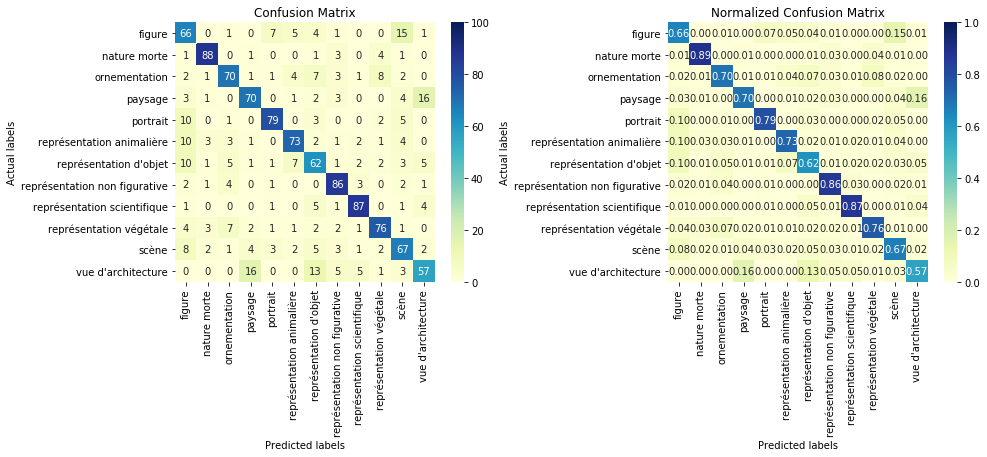

In [267]:
show_confusion_matrix(y_true, y_pred, test_set.classes)

In [268]:
cat_dd = widgets.Dropdown(options= test_set.classes,
                         description='Categories:')

query_options = [ 'ALL',
                  'MATCH',
                  'NO MATCH',
                  'FALSE POSITIVES'
                ]

opt_ss = widgets.RadioButtons(options = query_options,
                             description = 'Query options',
                             value = 'ALL'  ,
                                layout=widgets.Layout(width='50%'))
display (cat_dd, opt_ss)

Dropdown(description='Categories:', options=('figure', 'nature morte', 'ornementation', 'paysage', 'portrait',…

RadioButtons(description='Query options', layout=Layout(width='50%'), options=('ALL', 'MATCH', 'NO MATCH', 'FA…

In [269]:
query = opt_ss.value
is_random = False
show_class =  test_set.class_to_idx[cat_dd.value] 

In [270]:
if query == 'ALL':
    classified_idx = np.nonzero(y_true == show_class)[0]
elif query == 'MATCH': 
    classified_idx = np.nonzero((y_true == y_pred) & (y_true == show_class))[0]
elif query == 'NO MATCH': 
    classified_idx = np.nonzero((y_true != y_pred) & (y_true == show_class))[0]
elif query == 'FALSE POSITIVES': 
    classified_idx = np.nonzero((y_true != y_pred) & (y_pred == show_class))[0]

In [271]:
classified_idx.shape

(34,)

C:\Users\abobashe\Documents\MonaLIA\MonaLIA 2.0\MonaLIA\util\visualization_helpers.py:492: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


image,crop,labels,prediction
,,"0figurefigure (homme, paysan, en pied, deprofil, extérieur, chapeau, chasseur,fusil)#figure (homme, paysan, en pied,de dos, extérieur, chapeau, chasseur,portant, fusil)M1011006312C:\Joconde\joconde\0482\m101101_016967_p.jpg",4portrait : 0.898figure : 0.070scène : 0.016représentation d'objet: 0.011représentation scientifique: 0.002représentation animalière: 0.001ornementation : 0.000vue d'architecture : 0.000représentation non figurative: 0.000nature morte : 0.000
,,0figurefigure (satyre)50410003758C:\Joconde\joconde\0014\m504101_96cn6453_p.jpg,5représentation animalière: 0.882scène : 0.072figure : 0.021représentation d'objet: 0.008ornementation : 0.006représentation végétale: 0.006paysage : 0.002représentation scientifique: 0.001portrait : 0.001nature morte : 0.000
,,"0figurefigure (homme, nu, agenouillé, prière)06070008066C:\Joconde\joconde\0490\m060701_0007820_p.jpg",5représentation animalière: 0.640figure : 0.117scène : 0.079représentation végétale: 0.053représentation d'objet: 0.047portrait : 0.035représentation scientifique: 0.008paysage : 0.007ornementation : 0.007représentation non figurative: 0.003
,,"0figurefigures mythologiques (les Grâces, femme: nu, de dos, de face, de profil)000PE002310C:\Joconde\joconde\0002\m503604_87ee2315_p.jpg",10scène : 0.702représentation d'objet: 0.146figure : 0.043vue d'architecture : 0.041représentation non figurative: 0.023ornementation : 0.016représentation végétale: 0.008représentation scientifique: 0.006représentation animalière: 0.005portrait : 0.005
,,"0figurefigure (homme, Chopin Frédéric,compositeur, mort, bouquet : fleur)000SC033409C:\Joconde\joconde\0648\m500706_09-583763_p.jpg",4portrait : 0.735figure : 0.241ornementation : 0.013représentation végétale: 0.004représentation animalière: 0.003scène : 0.002représentation scientifique: 0.001vue d'architecture : 0.000paysage : 0.000représentation d'objet: 0.000
,,"0figurefigure (poète, Le Parnasse)50350101282C:\Joconde\joconde\0101\m503501_d0101282-000_p.jpg",6représentation d'objet: 0.777scène : 0.201figure : 0.009représentation scientifique: 0.004vue d'architecture : 0.004représentation non figurative: 0.001paysage : 0.001portrait : 0.001ornementation : 0.001représentation animalière: 0.001
,,"0figurefigure (Pyrénées, homme, costumetraditionnel, berger, fumeur)00980004728C:\Joconde\joconde\0407\m009802_0002330_p.jpg",10scène : 0.872représentation animalière: 0.059figure : 0.038portrait : 0.021paysage : 0.005représentation végétale: 0.002représentation d'objet: 0.002ornementation : 0.001vue d'architecture : 0.001représentation scientifique: 0.000
,,"0figurefigure (homme : nu, en pied, de trois-quarts, aile) ; ciel, nuée, nuage000PE021934C:\Joconde\joconde\0042\m006504_0001545_p.jpg",10scène : 0.939figure : 0.049représentation animalière: 0.006portrait : 0.003paysage : 0.001nature morte : 0.001représentation d'objet: 0.001représentation végétale: 0.000représentation non figurative: 0.000ornementation : 0.000
,,0figurefigure (anthropomorphe)M0350002204C:\Joconde\joconde\0437\m035004_001050_p.jpg,2ornementation : 0.505représentation végétale: 0.313représentation animalière: 0.080scène : 0.043figure : 0.016portrait : 0.011paysage : 0.009nature morte : 0.008représentation non figurative: 0.008vue d'architecture : 0.003
,,"0figurefigure (homme, à l'antique, debout, nu,musique, lyre)06070011201C:\Joconde\joconde\0522\m060701_0008834_p.jpg",6représentation d'objet: 0.570figure : 0.402portrait : 0.018représentation animalière: 0.004ornementation : 0.002représentation scientifique: 0.002scène : 0.001représentation végétale: 0.001vue d'architecture : 0.000paysage : 0.000

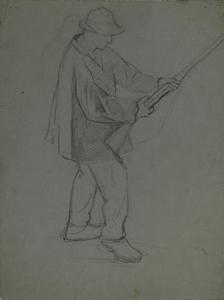
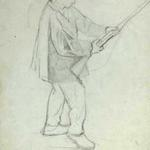
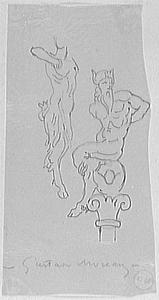
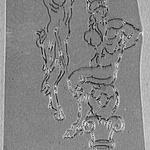
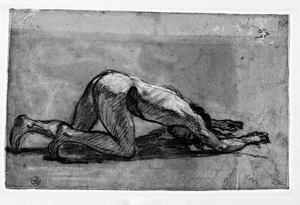
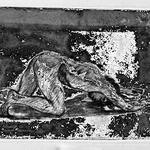
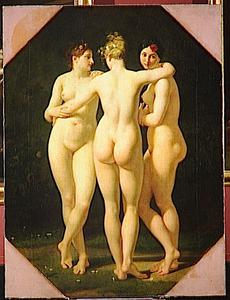
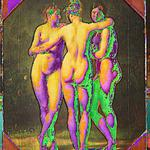
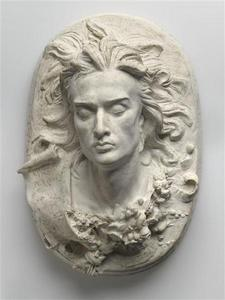
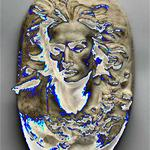
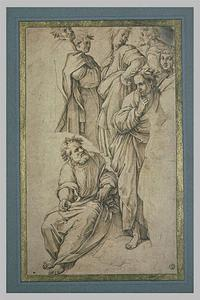
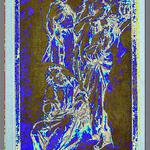
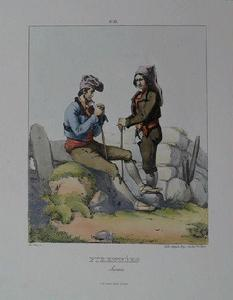
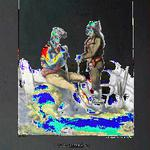
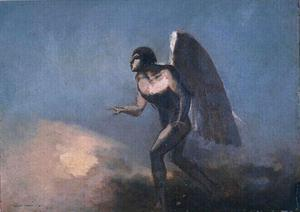
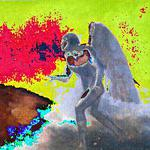
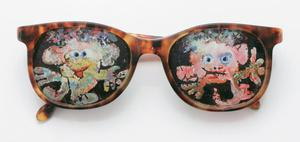
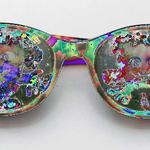
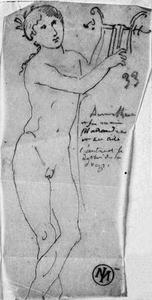
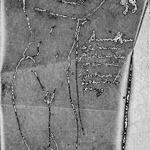
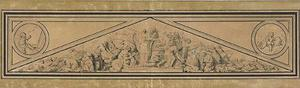
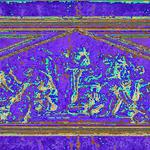
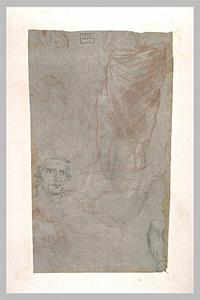
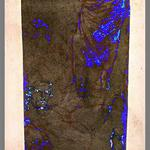
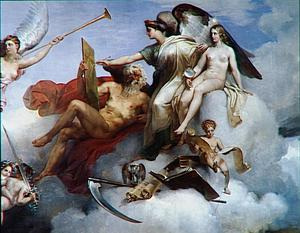
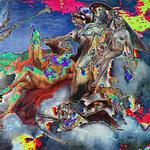
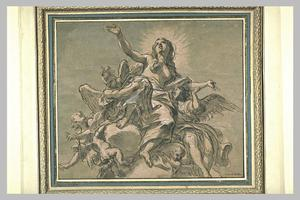
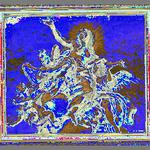
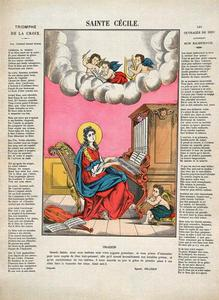
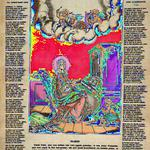
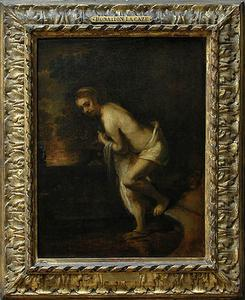
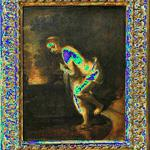
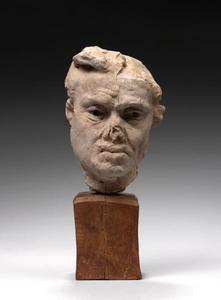
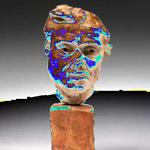
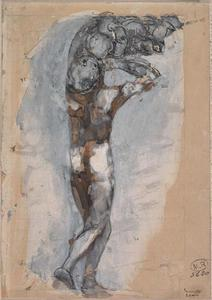
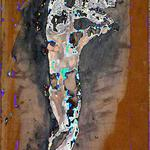
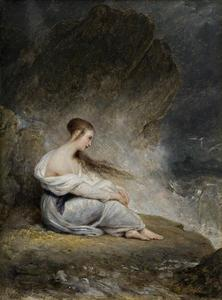
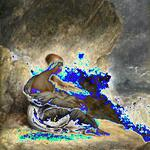
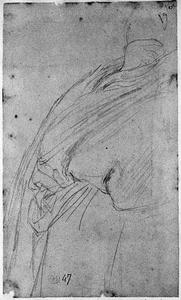
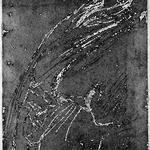
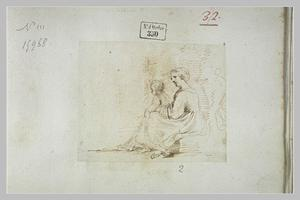
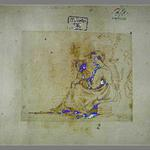
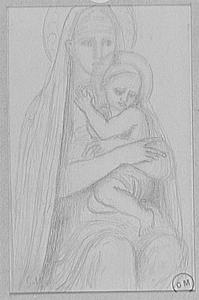
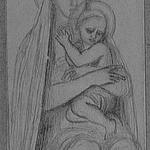
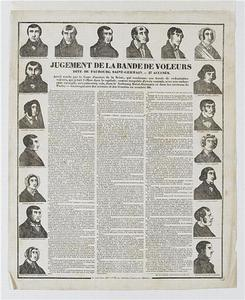
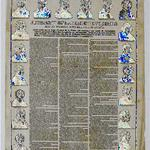
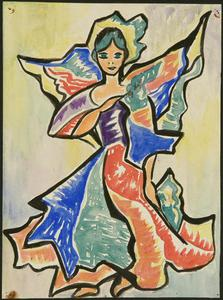
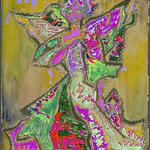
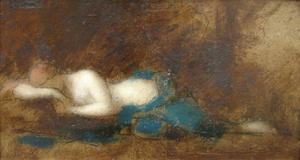
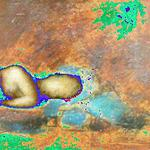
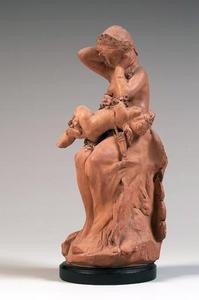
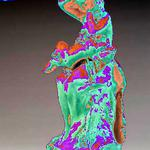
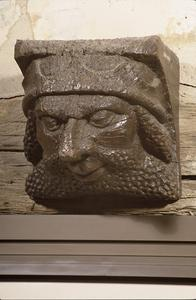
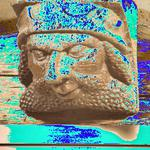
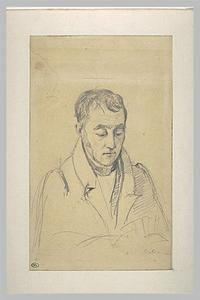
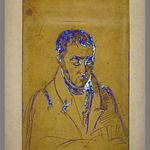
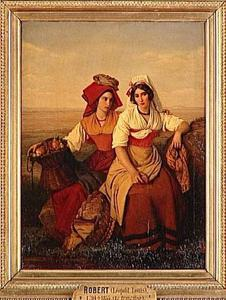
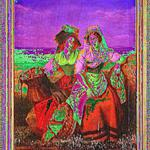
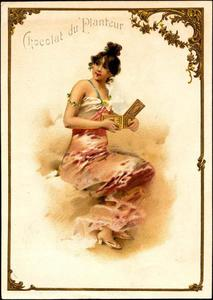
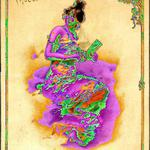
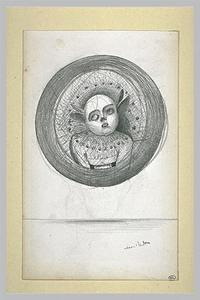
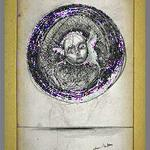
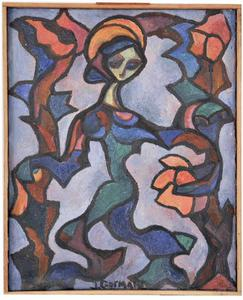
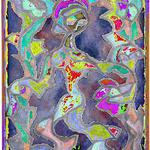
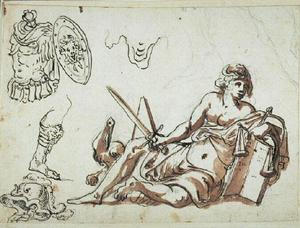
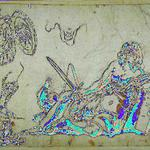
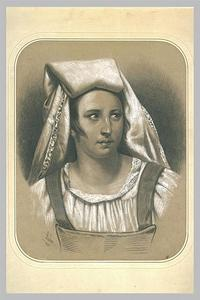
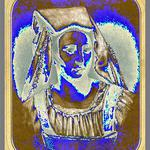

In [272]:
item_count = min(classified_idx.shape[0], 100)

if is_random:
    pick = np.random.randint(0, len(classified_idx), size=item_count)
else:
    pick = np.arange(item_count)

testset_idx_pick = classified_idx[pick]


#visualizer(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10)
HTML(display_HTML(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10))



### Output to HTML file

In [67]:
HTML(display_HTML(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10, file_name='lions_binary.softmax.FP.html'))

<IPython.core.display.HTML object>

### Output to csv file

In [370]:

df = pd.DataFrame(columns= ['reference' , 'repr', 'imageFile', 'image', 'label', 'prediction'])

df.reference = [test_set.samples[i][2] for i in testset_idx_pick]
df.repr = [test_set.samples[i][3] for i in testset_idx_pick]
df.imageFile = [test_set.samples[i][0].replace('/', '\\') for i in testset_idx_pick]

df.label = [target_to_text(test_set.classes,test_set.samples[i][1], separator=' | ') for i in testset_idx_pick]    
df.prediction = [prediction_to_text(test_set.classes, scores[i] , separator=' | ') for i in testset_idx_pick]

df.to_csv('lions_multilabel.20.csv', encoding='utf8', sep='\t')
#df